### Library Imports and Drive Mounting:
This section imports necessary libraries and mounts Google Drive to access stored data.

In [ ]:
!pip install git+https://github.com/salaniz/pycocoevalcap
!pip install nltk

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-jn7q15rv
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-jn7q15rv
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=69b39e4083e65f7ddaf7e0116df11c53d71d01a2481d72262d2ee82f702f1a34
  Stored in directory: /tmp/pip-ephem-wheel-cache-0smfwi_g/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [ ]:
import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import time
import matplotlib.pyplot as plt
import collections
import random
import requests
from math import sqrt
from PIL import Image
from tqdm.auto import tqdm
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.cider.cider import Cider

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load and Display Data:
This reads a CSV file containing image paths and their corresponding captions, then displays the first few rows.

In [ ]:
captions = pd.read_csv(f'/content/drive/MyDrive/data/captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
captions['image'] = captions['image'].apply(
    lambda x: f'/content/drive/MyDrive/data/Images/{x}'
)

Print the shape of dataset

In [ ]:
print('Dataset shape:', captions.shape)

Dataset shape: (40455, 2)


### Preprocessing Captions:
This defines a function to clean and format captions by making them lowercase, removing punctuation, adding start and end tokens, and applies it to all captions.

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [ ]:
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

,image,caption
0,/content/drive/MyDrive/data/Images/1000268201_...,[start] a child in a pink dress is climbing up...
1,/content/drive/MyDrive/data/Images/1000268201_...,[start] a girl going into a wooden building [end]
2,/content/drive/MyDrive/data/Images/1000268201_...,[start] a little girl climbing into a wooden p...
3,/content/drive/MyDrive/data/Images/1000268201_...,[start] a little girl climbing the stairs to h...
4,/content/drive/MyDrive/data/Images/1000268201_...,[start] a little girl in a pink dress going in...


[start] a girl in martial arts class is kicking a dummy [end]



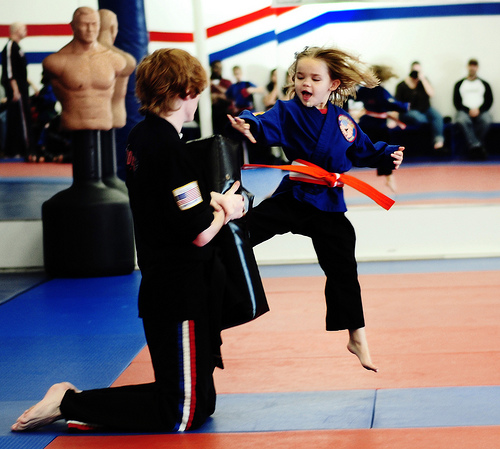

In [ ]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

### Model Configuration:
Sets parameters like the maximum length of captions, vocabulary size, and model dimensions.

In [ ]:
MAX_LENGTH = 40
VOCABULARY_SIZE = 10000
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EMBEDDING_DIM = 512
UNITS = 512

### Tokenizer Setup:
Initializes a tokenizer to vectorize text captions, configuring it to handle up to a set vocabulary size and padding to a maximum length.
Together, these two steps prepare the lexer to convert any given text (in the same format as the training data) into sequences of integers that can be fed into the neural network model.

Create the TextVectorisation layer.
tf.keras.layers.TextVectorization: this is a layer that preprocesses text into a format that can be used as input to a neural network. It simplifies the process of segmentation, i.e. the conversion of text to digital tokens.

max_tokens=VOCABULARY_SIZE: This parameter sets the maximum size of the vocabulary for the segmenter. It limits the number of unique words that the model will consider. Here VOCABULARY_SIZE may be a predefined constant specifying how many words are included in the vocabulary.

standardize=None: By default, TextVectorization may perform some standardisation operations, such as converting text to lowercase, removing punctuation, etc. Setting this to None means that no standardisation is automatically applied, which provides full control over how the text is processed (note: in this notebook, custom pre-processing is applied before word splitting).

output_sequence_length=MAX_LENGTH: This parameter defines the length of the output sequence. If the split text is shorter than MAX_LENGTH, it will be padded with zeros; if it is longer than that, it will be truncated.

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize=None,
    output_sequence_length=MAX_LENGTH)

tokenizer.adapt(captions['caption'])

### Training set and validation set

This code creates two StringLookup layers for converting between text tokens (words) and their indexes in the vocabulary.

The combination of these two layers provides fast conversion between text and indexes. word2idx layer is used to convert text tokens to indexes during preprocessing and model training, while the idx2word layer is used to convert the model's numerical output back to the corresponding word

tf.keras.layers.StringLookup: this is a layer that looks up the index of a string in a given vocabulary. Here it is used to convert the word to the corresponding index value.

mask_token=‘’: this parameter sets the mask token. The mask token is used to populate the elements that are not involved in the training. Here, it is set to the empty string to indicate that no mask is used.

vocabulary=tokenizer.get_vocabulary(): this parameter specifies the vocabulary, i.e., the vocabulary generated by the tokeniser classifier. This vocabulary contains all unique words and their indexes.

In [ ]:
word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

Initialise img_to_cap_vector dictionary.

This line of code creates a default dictionary using defaultdict, which is automatically initialised to an empty list when a non-existent key is accessed. This data structure is used to store one or more descriptions corresponding to each image.

Filling the dictionary.

This loop iterates over all the image paths and corresponding descriptions, adding each description to the list of images it corresponds to. zip The zip function merges the two lists captions[‘image’] and captions[‘caption’] into an iterator whose elements are paired (img, cap) tuples.

Randomly upset the order of image keys :.

Get the keys (i.e. paths) of all images from the dictionary and randomly upset the list of these keys. This step is to ensure randomness when dividing the data.

Split keys to create training and validation sets.

Calculate 90% of the positions in the list of keys to be used as the split point between the training and validation sets. Thus, 80% of the data is used for training and the remaining 10% is used for validation.

Construction of training set.

Iterate through the keys of the images in the training set, copying their paths multiple times for each image key (equal to the number of descriptions corresponding to that image) and collecting all corresponding descriptions. This ensures that each description appears with its corresponding image during training.

Constructing Validation Set.

Similar to the process of building the training set, traverse the image keys of the validation set, copy the image paths, and collect all the corresponding descriptions.

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(captions['image'], captions['caption']):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.9)
img_name_train_keys, img_name_val_keys = (img_keys[:slice_index],
                                          img_keys[slice_index:])

train_imgs = []
train_captions = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    train_imgs.extend([imgt] * capt_len)
    train_captions.extend(img_to_cap_vector[imgt])

val_imgs = []
val_captions = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    val_imgs.extend([imgv] * capv_len)
    val_captions.extend(img_to_cap_vector[imgv])

In [ ]:
len(train_imgs), len(train_captions), len(val_imgs), len(val_captions)

(36405, 36405, 4050, 4050)

Load and pre-process image data and corresponding text descriptions so that they can be used to train image description generation models.

In [ ]:
def load_data(img_path, caption):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = img / 255.
    caption = tokenizer(caption)
    return img, caption

Create training dataset: tf.data.

tf.data.Dataset.from_tensor_slices: This function creates a tf.data.Dataset object that slices the given tuple (train_imgs, train_captions), each slice contains an image path and a corresponding description. train_imgs is a list of paths to image files and train_captions is a list of corresponding text descriptions. imgs is a list of paths to image files and train_captions is a list of corresponding text descriptions.

Map the handler function and configure the training dataset: .map(load_data, num_parallel_calls=tf.data.

.map(load_data, num_parallel_calls=tf.data.AUTOTUNE): Use the map function to apply the previously defined load_data function to each element of the dataset. load_data function is responsible for loading and preprocessing the images and their descriptions. num_parallel_calls=tf.data. calls=tf.data.AUTOTUNE allows TensorFlow to automatically adjust the number of parallel processing elements to optimise runtime performance.
.shuffle(BUFFER_SIZE): The dataset is randomly shuffled where BUFFER_SIZE is the buffer size specified to determine how many elements are extracted from the dataset when performing the random shuffle.
.batch(BATCH_SIZE): The dataset is processed in batches, each containing BATCH_SIZE elements. This is so that multiple samples can be processed at once to improve computational efficiency when training the model.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_imgs, train_captions))

train_dataset = train_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_imgs, val_captions))

val_dataset = val_dataset.map(
    load_data, num_parallel_calls=tf.data.AUTOTUNE
    ).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Create a TensorFlow Keras sequence model that is specialised in image enhancement to increase the diversity and robustness of the data on which the model is trained. Image enhancement helps the model to better generalise to unseen data and simulate new scenarios by introducing small changes during training.

Random Horizontal Flip.

RandomFlip(‘horizontal’): this layer randomly flips the image horizontally (left and right upside down). This type of enhancement is appropriate for most natural images, since horizontal flipping of natural scenes usually does not change the semantics of the image.

RandomRotation.

RandomRotation(0.2): this layer is able to randomly rotate the image by an angle in the range of -20% to +20% (since 0.2 is the percentage of maximum arc of the angle). This random rotation simulates a slight change in camera angle during the shot.

Random Contrast Adjustment.

RandomContrast(0.3): this layer randomly adjusts the contrast of the image by up to 30%. The change in contrast makes the model more robust to changes in lighting conditions.

This enhancement model can be integrated into the data preprocessing process and applied to the training image dataset. The use of such an enhancement method can improve the model's adaptability and accuracy to various visual variations in real-world applications. When training the neural network model, these random image variations help the model learn to recognise the same content under different visual representations, thus improving the generalisation ability of the model.

In [ ]:
image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

This function defines a CNN encoder for feature extraction, based on the pre-trained InceptionV3 model.

Loading the InceptionV3 model.

InceptionV3: This is a deep convolutional neural network architecture developed by Google, commonly used for image recognition and classification tasks.
include_top=False: This parameter specifies that the top layer (i.e. the fully connected layer) is not included when loading the model. The reason for this is that we only want to use the convolutional base part of the model to extract features from the image, not for classification.
weights=‘imagenet’: use the weights pre-trained on the ImageNet dataset so that the model has learnt the ability to extract features from a large number of images.

Setting the model trainable property.

Prevents the weights of InceptionV3 from being updated during training by setting the trainable property to False. This means that all layers of the convolutional base will not be changed during training and will only be used as a feature extractor.

Get and transform the model output.

inception_v3.output: gets the output of the InceptionV3 model.

tf.keras.layers.Reshape: reshape layers used to change the dimensionality of the output. The -1 here causes TensorFlow to automatically calculate the size of this dimension, keeping the total amount of data constant. This converts the 2D feature maps from the convolutional layer to 1D, making them suitable for subsequent processing.

Create and return a CNN model.

Create a new model via tf.keras.models.Model that takes the input from InceptionV3 as input and the reshaped output as output. This new model can now be used as an encoder to provide image features in image description generation tasks.

Overall, the CNN_Encoder function creates an encoder dedicated to extracting high-level features from an image that can subsequently be used to drive image description generation. By using a pre-trained network, we leverage the power of deep learning in the area of image recognition while maintaining the efficiency and simplicity of model training.

In [ ]:
def CNN_Encoder():
    inception_v3 = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet'
    )
    inception_v3.trainable = False

    output = inception_v3.output
    output = tf.keras.layers.Reshape(
        (-1, output.shape[-1]))(output)

    cnn_model = tf.keras.models.Model(inception_v3.input, output)
    return cnn_model

This class TransformerEncoderLayer defines an implementation of a Transformer encoder layer, a type of layer that is based on a self-attention mechanism and is commonly used to process sequential data (such as text or time series).

The constructor __init__

embed_dim: embedding dimension, specifies the dimensions of the input and output vectors.

num_heads: number of heads in the multi-head attention mechanism. Multi-head attention is at the heart of the Transformer architecture, allowing models to learn information in parallel on different representation subspaces.

self.layer_norm_1 and self.layer_norm_2: layer normalisation, used to normalise activations in the network to help speed up the training process and improve generalisation.

self.attention: multi-head attention layer, sets the number of heads and the dimension of each head.

self.dense: fully connected layer used to add additional nonlinear transformations after the attention operation.

Call method call

x: the features input to the encoder layer.

training: a boolean value indicating whether the layer is running in training mode or inference mode.

self.layer_norm_1(x): normalise the input x.

self.dense(x): add nonlinearity by processing through the fully connected layers.

self.attention(...) : Performs a multi-head attention operation where query, key, and value are all the same input x. This is a feature of self-attention.

x + attn_output: sums the output of the attention layer with the original input, implementing residual concatenation, which helps avoid the problem of vanishing gradients in deep networks.

self.layer_norm_2(...) : normalises the result of the residual join.

The structure of such layers reflects the typical design of Transformer models, including the self-attention mechanism and layer normalisation, which are key components for implementing effective sequence processing networks. Such encoder layers can be stacked multiple times to build deeper Transformer models for more complex tasks such as language modelling, image description generation, etc.

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")


    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

This Embeddings class is a TensorFlow Keras layer for implementing the embeddings part of the Transformer architecture, which combines lexical and positional embeddings.

The constructor __init__

vocab_size: the size of the vocabulary, i.e. the number of different words that the model can recognise.

embed_dim: the embedding dimension of each vocabulary and position.

max_len: maximum length of the input sequence.

self.token_embeddings: vocabulary embedding layer, generates an embedding vector for each vocabulary identifier (token).

self.position_embeddings: position embedding layer, generate an embedding vector for each position in the sequence, even if two same words appear in different positions, they will have different representations.

Call methods call

input_ids: an integer tensor containing the vocabulary index of the input sequence.

length: get the size of the last dimension of the input tensor input_ids, i.e. the length of the sequence.

position_ids: generate a sequence of integers from 0 to length-1, which is used to index positional embeddings.

tf.expand_dims(position_ids, axis=0): add a dimension so that position IDs can be used with multiple sequences in a batch.

token_embeddings: map input_ids to their embedding vectors through the self.token_embeddings layer.

position_embeddings: maps the generated position_ids to their embedding vectors via the self.position_embeddings layer.

Finally, the method returns the element-by-element sum of the lexical and positional embeddings. This combination ensures that the model learns not only the meaning of each word, but also the relative or absolute position of each word in the sentence, which is crucial for processing linguistic and other forms of sequence data. This technique is standard practice in Transformer networks for maintaining information about sequence order, thereby improving the model's ability to understand sequence data.

In [ ]:
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embeddings = tf.keras.layers.Embedding(
            vocab_size, embed_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            max_len, embed_dim, input_shape=(None, max_len))


    def call(self, input_ids):
        length = tf.shape(input_ids)[-1]
        position_ids = tf.range(start=0, limit=length, delta=1)
        position_ids = tf.expand_dims(position_ids, axis=0)

        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        return token_embeddings + position_embeddings

This code instantiates the previously defined Embeddings class and makes a single call through a batch of the training dataset to check the shape of the output.

Instantiating the Embeddings class.

tokenizer.vocabulary_size(): gets the size of the vocabulary list in the tokeniser, which is one of the parameters needed for the lexical embedding layer.

EMBEDDING_DIM: dimension of the embedding vector, a global variable defined earlier to control the output dimension of the embedding layer.

MAX_LENGTH: the maximum allowed sequence length, a global variable defined earlier to be used by the positional embedding layer to ensure that embeddings can be generated for any sequence position that may appear in the dataset.

Get a batch of the training dataset: the

train_dataset: the previously created training dataset, which is a batch of preprocessed images and annotations.

next(iter(train_dataset)): get the first batch of the training dataset from the iterator.

[1]: select the labelled data from the batch (image is the 0th element, labelling is the 1st element).

Calling Embeddings instances.

Calls an instance of Embeddings and passes in the selected annotation data. This will apply lexical embedding and positional embedding to the input annotations (text data).
View Output Shape: View the output shape.

View the shape of the embedding output by accessing the .shape property. This will provide information about the dimensionality of the output of the embedding layer, which is important to ensure that the input and output dimensions of the model's layers match.

The output of this code will be a tensor shape showing the dimension of the embedding representation for each sequence in the batch. In general, the output shape will be (batch_size, sequence_length, EMBEDDING_DIM) where batch_size is the number of sequences in the batch, sequence_length is the length of the sequences (up to MAX_LENGTH), and EMBEDDING_DIM is the dimensionality of the embedding representation for each of the dimension of the embedding vector. This embedding representation is the basis for training Transformer networks or other models that require sequence input.

In [ ]:
Embeddings(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)(next(iter(train_dataset))[1]).shape

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


TensorShape([32, 40, 512])

This class TransformerDecoderLayer defines the decoder layer in the Transformer model. This layer is responsible for generating output sequences and is typically used for tasks such as machine translation and text generation.

Constructor __init__

Embedding layer (self.embedding): provides an embedding representation for the decoder input using the Embeddings class defined earlier.

Attention layers (self.attention_1 and self.attention_2): the first multi-head attention layer is responsible for handling the self-attention inside the decoder, while the second multi-head attention layer is used to handle the attention at the output of the encoder.

Layer normalisation (self.layernorm_1, self.layernorm_2, self.layernorm_3): this is used to normalise the outputs of the different layers and helps stabilise the training process.

Feedforward network (self.ffn_layer_1 and self.ffn_layer_2): a feedforward network consisting of two fully connected layers, used to add non-linear processing inside the decoder.

Output layer (self.out): the last fully-connected layer that generates the final prediction (i.e. the probability distribution of the next word) using the softmax activation function.

Dropout (self.dropout_1 and self.dropout_2): used to reduce overfitting by randomly dropping a part of the network connections.

Call method call

Input parameters: input_ids: decoder inputs

input_ids: IDs of the tokens to be input to the decoder.

encoder_output: output from the previous

Transformer encoder layer.

training: Indicates whether the layer is running in training or inference mode.

mask: Used to mask parts of the input that should not be noticed (e.g., padded zeros).

Process.

Generate embeddings: Converts input tokens into embedded representations.

Self-attention: The first multi-attention layer processes the self-attention of the decoder input.

Encoder-Decoder Attention: The second MCA layer processes the output from the encoder and the current state of the decoder.

Feedforward network: A two-layer fully connected network is applied to add non-linear processing.

Output prediction: Calculate the probability distribution of the next word.

Generate causal attention mask get_causal_attention_mask

This method generates a causal mask to ensure that only previous words are used when generating the current word, ensuring the autoregressive nature of the decoding process. This mask is used in the self-attention computation to prevent information from ‘leaking’ from future tokens.

This class is a core part of building the Transformer decoder, which integrates several sub-layers and operations to generate the output sequence, while using the encoder's output to improve the quality of the generation.

In [ ]:
class TransformerDecoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embeddings(
            tokenizer.vocabulary_size(), embed_dim, MAX_LENGTH)

        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.ffn_layer_1 = tf.keras.layers.Dense(units, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.out = tf.keras.layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)


    def call(self, input_ids, encoder_output, training, mask=None):
        embeddings = self.embedding(input_ids)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

This ImageCaptioningModel class defines a complete image captioning generation model that integrates a convolutional neural network (CNN) model, encoder, decoder, and optional image enhancement. The components and methods of the model are explained in detail below:

Constructor __init__

Parameters.

cnn_model: convolutional neural network model used to extract image features.

encoder: encoder model for processing image features or other coded inputs.

decoder: Decoder model for generating text descriptions based on the encoder output.

image_aug: Optional image augmentation model to add diversity to the data during training.

Attributes: loss_tracker and acc_tracker

loss_tracker and acc_tracker: Used to track the average loss and accuracy during training and evaluation.

Auxiliary methods calculate_loss and calculate_accuracy

These methods are used to calculate the loss and accuracy of the model, taking into account the mask, so that only the valid part of the output can be calculated (ignoring the padded part).

Methods compute_loss_and_accuracy

Computes the output of the encoder and decoder, based on the given image embedding and description, while calculating the loss and accuracy.

Training and testing steps train_step and test_step

These methods define how to perform a training step and a test step on a batch of data. This includes forward pass of data, loss calculation, gradient calculation, parameter update, etc.

The train_step may include image enhancement processing, while the test_step does not.

Gradients are computed and applied automatically using the gradient tape (tf.GradientTape).

Attribute metrics

Provides metrics that the model should track during training.

This class combines several high-level concepts in deep learning to form a complete system for generating image descriptions. It is able to handle the entire process from the raw image to the final textual description, while providing a complete definition of training and testing, which allows the model to be effectively trained and evaluated in real-world applications.

In [ ]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

A complete image description generation model is instantiated, integrating a Convolutional Neural Network (CNN) encoder, a Transformer encoder layer, a Transformer decoder layer, and image enhancement.

Instantiating the CNN Encoder

This line of code calls the previously defined CNN_Encoder class to create a new instance of a CNN model, based on InceptionV3, for extracting a feature from an image. This feature will be used as input to the encoder in the image description generation process.

Instantiating the Transformer Encoder and Decoder Layers

TransformerEncoderLayer and TransformerDecoderLayer are custom layers based on the Transformer architecture. Here, the encoder and decoder layers are configured to use a specific embedding dimension (EMBEDDING_DIM) and different parameters.

The encoder layer uses one attention head (num_heads=1), which may be less than typical Transformer architectures and can often affect performance, but can be suitable for some simplified applications or small datasets.
The decoder layer is configured with more attention heads (num_heads=8) and number of units (UNITS), which helps to handle more complex dependencies and learn more detailed features.

Instantiating the Image Captioning Generation Model

The ImageCaptioningModel is the core of the entire image captioning generation system, combining the CNN model, the Transformer encoder and decoder, and the image enhancement features.

image_aug=image_augmentation: passes the image enhancement module to the image description model to be applied during training to improve the robustness of the model to image changes.

This code successfully sets up a deep learning model for image description tasks that integrates several advanced components for application scenarios that require understanding the content of an image and generating a corresponding textual description. In this way, the model is able to learn how to extract key information from visual data and convert it into natural language descriptions.

In [ ]:
encoder = TransformerEncoderLayer(EMBEDDING_DIM, 1)
decoder = TransformerDecoderLayer(EMBEDDING_DIM, UNITS, 8)

cnn_model = CNN_Encoder()
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


This code is using the TensorFlow and Keras libraries to set up the configuration of the optimiser, loss function, early stopping mechanism, and learning rate scheduling strategy used during the training of a neural network. Below is a detailed explanation of each section:

##### 1. Defining the optimiser
The code defines a dictionary called `optimizers` containing three different optimisers; SGD, Adam and RMSprop. these optimisers are used for parameter updating of the network.

- **SGD (Stochastic Gradient Descent)**: has a learning rate of 0.01 and a momentum of 0.9. Momentum helps to speed up the optimisation of SGD in the direction of interest and suppresses oscillations.
- **Adam**: adaptive moment estimation optimiser that starts with a small default learning rate of 0.001, combining the benefits of AdaGrad and RMSProp.
- **RMSprop**: also an adaptive learning rate method for non-smooth targets, with the learning rate also set to 0.001.

##### 2. loss function
`cross_entropy` defines the use of sparse classification cross entropy as the loss function, commonly used in multi-classification problems. Here `from_logits=False` means that the expected output should be in the form of a probability distribution, not logits. `reduction=‘none’` indicates that the function does not automatically average or sum, and returns the loss for each sample.

##### 3. Early Stopping Mechanism (Early Stopping)
`early_stopping` is a callback function to prevent overfitting. Its parameter `patience=10` indicates that training is stopped if there is no improvement in performance on the validation set for 10 consecutive training cycles. `restore_best_weights=True` Indicates to revert to the best performing model parameters.

##### 4. Learning rate scheduler
The `scheduler` function adjusts the learning rate `lr` based on the number of rounds of training `epoch`:
- The initial learning rate is kept constant for the first 5 rounds.
- For the first 5 rounds, the initial learning rate is kept constant. For rounds 5 through 10, the learning rate is reduced to 10% of the original rate.
- After the 10th round, the learning rate is further reduced to 1% of the original learning rate.

##### Applying the learning rate scheduler
The learning rate schedulers for the three optimisers are `learning_rate_callback_adam`, `learning_rate_callback_sgd` and `learning_rate_callback_rmsprop`. Although the same `scheduler` function is used here, it can be passed to different optimisers to adjust their learning rates separately.

This configuration provides a flexible mechanism for optimising, preventing overfitting and dynamically adjusting the learning rate for neural network training, which helps to improve the performance and stability of the model.

In [ ]:
# Defining the optimiser and learning rate adjustment
optimizers = {
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001)
}

cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


In [ ]:
# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * 0.1
    else:
        return lr * 0.01

# Applying different learning rate schedulers
learning_rate_callback_adam = LearningRateScheduler(scheduler)
learning_rate_callback_sgd = LearningRateScheduler(scheduler)
learning_rate_callback_rmsprop = LearningRateScheduler(scheduler)

Functions for loading and pre-processing images

This function is responsible for reading the image file, decoding the JPEG image and resizing it to 299x299 pixels (which is usually related to the input size of the model). Finally, it converts the data type of the image data to float32 and normalises it (pixel values ranging from 0 to 1).

Functions to generate image descriptions

This function first calls load_image_from_path to load and process the image. Then, it generates an embedded representation of the image using a CNN model of caption_model, which is usually an encoder model. Next, a loop generates each word until the maximum length MAX_LENGTH is reached or the termination token [end] is generated. In the loop, the generated subtitle text is converted into tokens using a tokeniser and the prediction for the next word is generated using a decoder. Finally, the generated subtitle removes the start token [start] from the string and returns it.

In [ ]:
# Initialising a dictionary
actual_captions = collections.defaultdict(list)

# Populating a dictionary with data from a pandas DataFrame
for img, cap in zip(captions['image'], captions['caption']):
    actual_captions[img].append(cap)

In [ ]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    # img = img / 255.
    img = tf.cast(img, tf.float32) / 255.0
    return img


def generate_caption(img_path):
    img = load_image_from_path(img_path)
    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(MAX_LENGTH-1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

This code describes the process of training and evaluating the performance of an image caption generation model using multiple optimisers.

##### 1. Initialising the results and scoring storage structure
Multiple dictionaries are defined to store training results, history, and BLEU and CIDEr scores.

##### 2. Training the model
Loop through each optimiser and compile and train the model.

- **Compile model**: use the selected optimiser and loss function.
- **Train the model**: training is performed on the specified training set, while performance is verified using the validation set. The training also uses an early stopping mechanism and a learning rate scheduling callback function for the corresponding optimiser.

##### 3. Save training results
After training, the historical data and the main results (training and validation losses) are saved to the dictionary.

##### 4. Generate subtitles
Generate a caption for a randomly selected image in the validation set to show the actual effect of the model and visualise the image.

##### 5. Calculate scores
Evaluate the generated caption:
- **BLEU score**: use `corpus_bleu` to calculate the BLEU score between the reference caption and the generated caption.
- **CIDEr score**: first process the reference subtitle and the generated subtitle as a single string, then calculate the CIDEr score using `Cider`.

##### Additional notes
Using different learning rate schedulers for different optimisers helps to adjust the learning rate during training to improve model performance or avoid overfitting.

Training with SGD
Epoch 1/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 79s 65ms/step - acc: 0.3983 - loss: 3.0756 - val_acc: 0.3792 - val_loss: 3.3619 - learning_rate: 1.0000e-03
Epoch 2/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - acc: 0.4066 - loss: 3.0061 - val_acc: 0.3827 - val_loss: 3.3434 - learning_rate: 1.0000e-03
Epoch 3/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - acc: 0.4080 - loss: 2.9774 - val_acc: 0.3838 - val_loss: 3.3156 - learning_rate: 1.0000e-03
Epoch 4/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - acc: 0.4096 - loss: 2.9598 - val_acc: 0.3836 - val_loss: 3.3016 - learning_rate: 1.0000e-03
Epoch 5/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - acc: 0.4107 - loss: 2.9401 - val_acc: 0.3857 - val_loss: 3.2896 - learning_rate: 1.0000e-03
Epoch 6/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - acc: 0.4129 - loss: 2.9300 - val_acc: 0.3867 - val_loss: 3.2905 - learning_rate: 1.0000e-04
Epoch 7/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - acc: 0.4135 - loss: 2.92

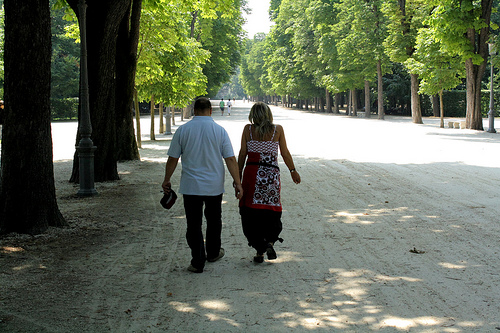

BLEU score for SGD: 4.556503981433192e-233
CIDEr score for SGD: 0.0
Training with Adam
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

1138/1138 ━━━━━━━━━━━━━━━━━━━━ 87s 70ms/step - acc: 0.3926 - loss: 3.0871 - val_acc: 0.3726 - val_loss: 3.3513 - learning_rate: 0.0010
Epoch 2/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - acc: 0.4006 - loss: 2.9468 - val_acc: 0.3727 - val_loss: 3.3376 - learning_rate: 0.0010
Epoch 3/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - acc: 0.4096 - loss: 2.8267 - val_acc: 0.3771 - val_loss: 3.3123 - learning_rate: 0.0010
Epoch 4/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - acc: 0.4222 - loss: 2.7063 - val_acc: 0.3833 - val_loss: 3.3035 - learning_rate: 0.0010
Epoch 5/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - acc: 0.4318 - loss: 2.6181 - val_acc: 0.3814 - val_loss: 3.3025 - learning_rate: 0.0010
Epoch 6/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - acc: 0.4500 - loss: 2.4523 - val_acc: 0.3958 - val_loss: 3.2326 - learning_rate: 1.0000e-04
Epoch 7/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - acc: 0.4673 - loss: 2.3381 - val_acc: 0.3977 - val_loss: 3.2151 - learnin

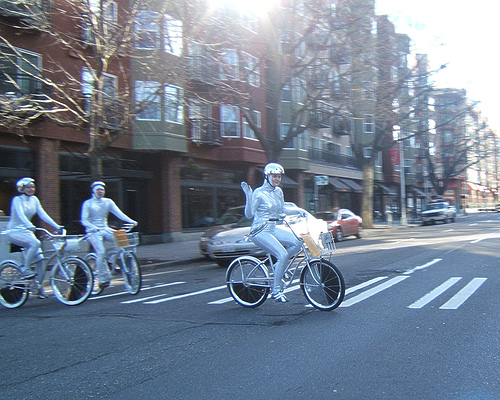

BLEU score for Adam: 5.363301776773146e-233
CIDEr score for Adam: 0.0
Training with RMSprop
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

1138/1138 ━━━━━━━━━━━━━━━━━━━━ 82s 66ms/step - acc: 0.4606 - loss: 2.3955 - val_acc: 0.3859 - val_loss: 3.4035 - learning_rate: 0.0010
Epoch 2/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - acc: 0.4583 - loss: 2.4711 - val_acc: 0.3849 - val_loss: 3.5525 - learning_rate: 0.0010
Epoch 3/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - acc: 0.4560 - loss: 2.5497 - val_acc: 0.3786 - val_loss: 3.6016 - learning_rate: 0.0010
Epoch 4/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - acc: 0.4533 - loss: 2.6164 - val_acc: 0.3793 - val_loss: 3.5648 - learning_rate: 0.0010
Epoch 5/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - acc: 0.4561 - loss: 2.6270 - val_acc: 0.3794 - val_loss: 3.5334 - learning_rate: 0.0010
Epoch 6/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - acc: 0.4662 - loss: 2.5831 - val_acc: 0.3921 - val_loss: 3.4589 - learning_rate: 1.0000e-04
Epoch 7/10
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - acc: 0.4745 - loss: 2.5217 - val_acc: 0.3941 - val_loss: 3.4339 - learnin

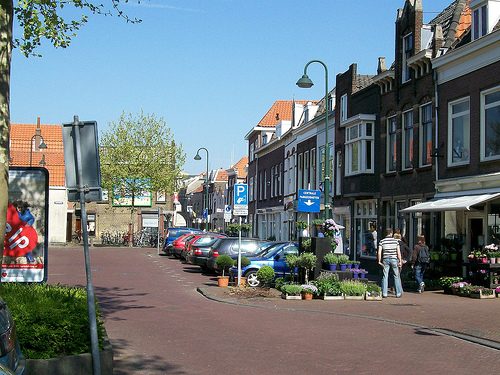

BLEU score for RMSprop: 1.1876644308499324e-232
CIDEr score for RMSprop: 0.0


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
# Recompile the model and train it according to the chosen optimiser
results = {}
history_dict = {}

bleu_scores = {}
cider_scores = {}


for name, opt in optimizers.items():
    print(f"Training with {name}")

    callback = {
        'SGD': learning_rate_callback_sgd,
        'Adam': learning_rate_callback_adam,
        'RMSprop': learning_rate_callback_rmsprop
    }[name]

    caption_model.compile(
      optimizer=opt,
      loss=cross_entropy
    )

    # model training
    history = caption_model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=[early_stopping, callback]  # 对于Adam使用调度器
    )


    # Save historical data
    history_dict[name] = history.history

    # Recording History
    results[name] = {
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }

    # Randomly select a validation set image to describe
    idx = random.randrange(0, len(val_imgs))
    img_path = val_imgs[idx]
    pred_caption = generate_caption(img_path)
    print(f'Predicted Caption with {name}:', pred_caption)
    print()
    img = Image.open(img_path)
    img.show()
    display(img)

    # Calculation of BLEU and CIDEr scores
    references = [actual_captions[img_path]]
    candidates = [pred_caption.split()]

    # BLEU score
    bleu_score = corpus_bleu(references, candidates)
    bleu_scores[name] = bleu_score

    # CIDEr score
    # For CIDEr, ensure that captions are single strings within the list
    cider_references = [' '.join(ref) for ref in actual_captions[img_path]]  # Convert each list of words back to string
    cider_candidates = [' '.join(pred_caption.split())]  # Make sure candidate is also a single string

    # Now prepare for CIDEr
    cider_scorer = Cider()
    score, _ = cider_scorer.compute_score({1: cider_references}, {1: cider_candidates})
    cider_scores[name] = score

    print(f"BLEU score for {name}: {bleu_score}")
    print(f"CIDEr score for {name}: {score}")



In [ ]:
print("Final BLEU scores:", bleu_scores)
print("Final CIDEr scores:", cider_scores)

Final BLEU scores: {'SGD': 4.556503981433192e-233, 'Adam': 5.363301776773146e-233, 'RMSprop': 1.1876644308499324e-232}
Final CIDEr scores: {'SGD': 0.0, 'Adam': 0.0, 'RMSprop': 0.0}


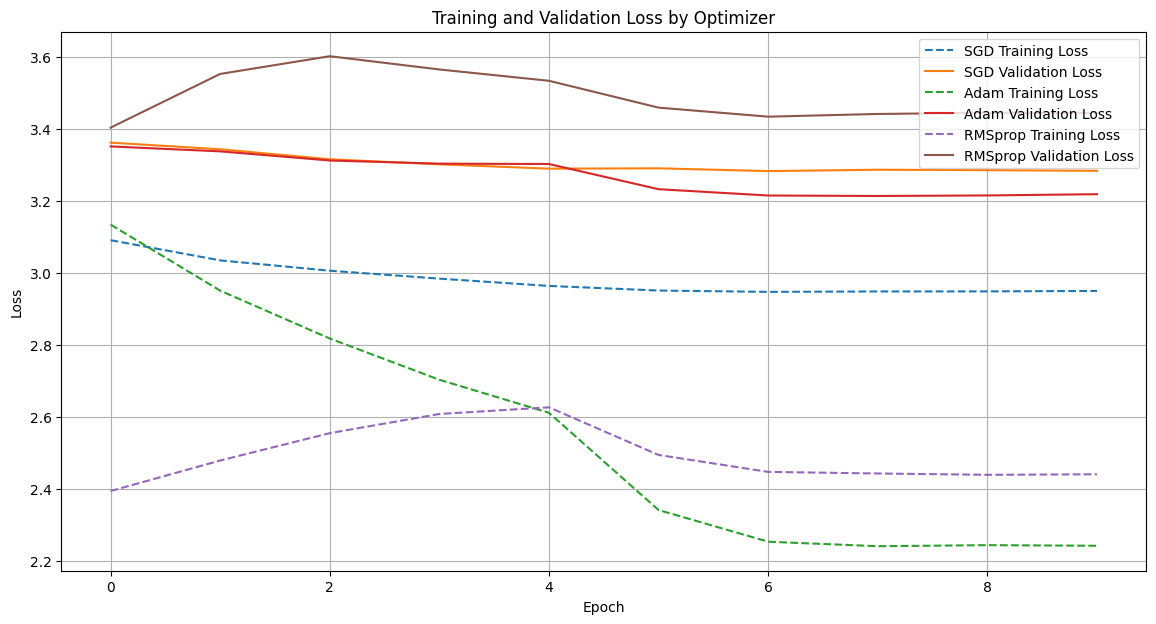

In [ ]:
plt.figure(figsize=(14, 7))
for name, history in history_dict.items():
    plt.plot(history['loss'], '--', label=f'{name} Training Loss')
    plt.plot(history['val_loss'], label=f'{name} Validation Loss')

plt.title('Training and Validation Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

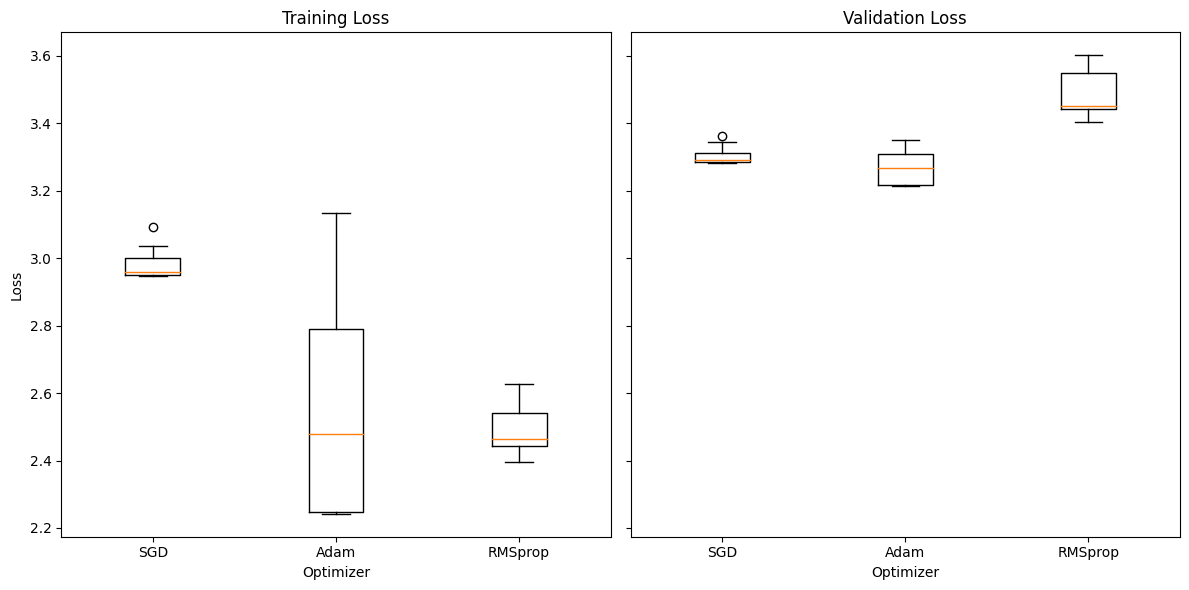

In [ ]:
loss_data = [results[optimizer]['loss'] for optimizer in results]
val_loss_data = [results[optimizer]['val_loss'] for optimizer in results]
labels = list(results.keys())

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax[0].boxplot(loss_data, labels=labels)
ax[0].set_title('Training Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Optimizer')

ax[1].boxplot(val_loss_data, labels=labels)
ax[1].set_title('Validation Loss')
ax[1].set_xlabel('Optimizer')

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
# Descriptive statistical analysis
data_sgd = np.array(results['SGD']['loss'])
data_adam = np.array(results['Adam']['loss'])
data_rmsprop = np.array(results['RMSprop']['loss'])

# Mean and standard deviation
mean_sgd = np.mean(data_sgd)
std_sgd = np.std(data_sgd)

print(f"SGD - Mean: {mean_sgd}, Standard Deviation: {std_sgd}")

# Skewness and kurtosis
skewness_sgd = stats.skew(data_sgd)
kurtosis_sgd = stats.kurtosis(data_sgd)

print(f"SGD - Skewness: {skewness_sgd}, Kurtosis: {kurtosis_sgd}")


SGD - Mean: 2.9828757524490355, Standard Deviation: 0.045760772536764034
SGD - Skewness: 1.2838866147928862, Kurtosis: 0.4531839781761784


In [ ]:
# t-test
from scipy import stats

# Independent samples t-test
t_stat, p_val = stats.ttest_ind(data_sgd, data_adam)
print(f"T-test between SGD and Adam - T-Stat: {t_stat}, P-Value: {p_val}")

t_stat, p_val = stats.ttest_ind(data_adam, data_rmsprop)
print(f"T-test between RMSprop and Adam - T-Stat: {t_stat}, P-Value: {p_val}")

t_stat, p_val = stats.ttest_ind(data_rmsprop, data_sgd)
print(f"T-test between SGD and RMSprop - T-Stat: {t_stat}, P-Value: {p_val}")

# Analysis of variance ANOVA
f_val, p_val_anova = stats.f_oneway(data_sgd, data_adam, data_rmsprop)
print(f"ANOVA test among SGD, Adam, RMSprop - F-Stat: {f_val}, P-Value: {p_val_anova}")


T-test between SGD and Adam - T-Stat: 3.9923620917395675, P-Value: 0.0008542384318962513
T-test between RMSprop and Adam - T-Stat: 0.5608025881966632, P-Value: 0.5818465235482091
T-test between SGD and RMSprop - T-Stat: -16.84118305289017, P-Value: 1.8302427023431995e-12
ANOVA test among SGD, Adam, RMSprop - F-Stat: 17.603515923830994, P-Value: 1.278138267780713e-05


In [ ]:
# Non-parametric testing
# Wilcoxon rank sum test (pairwise differences)
z_stat, p_val_wilcoxon = stats.wilcoxon(data_sgd, data_adam)
print(f"Wilcoxon test between SGD and Adam - Z-Stat: {z_stat}, P-Value: {p_val_wilcoxon}")

z_stat, p_val_wilcoxon = stats.wilcoxon(data_sgd, data_rmsprop)
print(f"Wilcoxon test between SGD and RMSprop - Z-Stat: {z_stat}, P-Value: {p_val_wilcoxon}")

z_stat, p_val_wilcoxon = stats.wilcoxon(data_adam, data_rmsprop)
print(f"Wilcoxon test between Adam and RMSprop - Z-Stat: {z_stat}, P-Value: {p_val_wilcoxon}")

# Kruskal-Wallis H-test
h_stat, p_val_kruskal = stats.kruskal(data_sgd, data_adam, data_rmsprop)
print(f"Kruskal-Wallis test among SGD, Adam, RMSprop - H-Stat: {h_stat}, P-Value: {p_val_kruskal}")


Wilcoxon test between SGD and Adam - Z-Stat: 1.0, P-Value: 0.00390625
Wilcoxon test between SGD and RMSprop - Z-Stat: 0.0, P-Value: 0.001953125
Wilcoxon test between Adam and RMSprop - Z-Stat: 26.0, P-Value: 0.921875
Kruskal-Wallis test among SGD, Adam, RMSprop - H-Stat: 14.40774193548387, P-Value: 0.0007437013851522712


In [ ]:
# caption_model.save_weights('image_captioning_transformer_weights.weights.h5')